In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-car-prices-dataset/Sport car price.csv


**🚗 Car Price Prediction**
Dataset: Sport Cars Dataset
Goal: Predict car prices using features like Engine Size, Horsepower, etc.

### **Importing Library**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## **Data Loading & Inspection**

### **Reading Data**

In [3]:
Sport_car = pd.read_csv('/kaggle/input/sports-car-prices-dataset/Sport car price.csv')

In [4]:
Sport_car.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


In [5]:
Sport_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


In [6]:
Sport_car.shape

(1007, 8)

## **Data Cleaning**

### **Nulls**

In [7]:
Sport_car.isnull().sum()

Car Make                    0
Car Model                   0
Year                        0
Engine Size (L)            10
Horsepower                  0
Torque (lb-ft)              3
0-60 MPH Time (seconds)     0
Price (in USD)              0
dtype: int64

For extraction non numerical values at all features if found:

In [8]:
# num cols
numerical_cols = ['Car Make','Car Model','Engine Size (L)','Horsepower','Torque (lb-ft)','0-60 MPH Time (seconds)','Price (in USD)']

for col in numerical_cols:
    non_numeric = Sport_car[~Sport_car[col].apply(lambda x: str(x).replace('.','',1).isdigit())][col]
    print(f"Non-numeric values in '{col}' ({len(non_numeric)}):")
    print(non_numeric.values)
    print("\n")

Non-numeric values in 'Car Make' (1007):
['Porsche' 'Lamborghini' 'Ferrari' ... 'McLaren' 'Pagani' 'Rimac']


Non-numeric values in 'Car Model' (1004):
['Huracan' '488 GTB' 'R8' ... 'Senna' 'Huayra' 'Nevera']


Non-numeric values in 'Engine Size (L)' (59):
['Electric' 'Electric Motor' '1.5 + Electric' 'Electric' 'Electric' nan
 nan 'Electric' nan nan 'Electric' 'Electric' 'Electric' 'Electric'
 'Electric' 'Electric' '-' 'Electric' 'Electric' 'Electric' nan nan
 'Electric (tri-motor)' 'Electric' 'Electric' 'Electric' 'Electric'
 'Electric' 'Electric' 'Electric' 'Electric' 'Electric' 'Electric'
 'Electric (93 kWh)' 'Electric (100 kWh)' 'Hybrid (4.0)' 'Electric'
 'Electric' nan nan 'Electric' 'Hybrid' nan 'Electric' 'Electric'
 '2.0 (Electric)' '4.0 (Hybrid)' 'Electric' 'Electric' 'Electric' nan
 'Electric' 'Electric' 'Hybrid' 'Electric' 'Electric' 'Electric'
 'Electric Motor' 'Electric Motor']


Non-numeric values in 'Horsepower' (9):
['1000+' '1000+' '1000+' '1,000+' '10000+' '10,000' '

For replace non numerical values to numerical columns that can make model prediction well

To clean **Engine Size (L) feature:**

In [9]:
# Function to clean Engine Size
def clean_engine_size(val):
    try:
        val_str = str(val).strip()
        # If '+' exists, take the number before '+'
        if '+' in val_str:
            return float(val_str.split('+')[0])
        # Electric or Hybrid cars → 0
        elif val_str.lower() in ['electric', 'electric motor', 'hybrid',
                                 'electric (tri-motor)', 'electric (93 kwh)', 'electric (100 kwh)',
                                 'hybrid (4.0)', '2.0 (electric)', '4.0 (hybrid)']:
            return 0
        # Symbols or NaN
        elif val_str in ['-', 'nan', '']:
            return np.nan
        else:
            return float(val_str)
    except:
        return np.nan

To clean **Torque (lb-ft) column and Horsepower:**

In [10]:
# Function to clean Horsepower and Torque
def clean_numeric(val):
    try:
        val_str = str(val).replace(',', '').replace('+','').strip()
        if val_str in ['-', 'nan', '']:
            return np.nan
        else:
            return float(val_str)
    except:
        return np.nan

To clean **0-60 Time:**

In [11]:
# Function to clean 0-60 Time
def clean_0_60(val):
    try:
        val_str = str(val).strip()
        if '<' in val_str:
            return float(val_str.replace('<',''))
        elif val_str in ['-', 'nan', '']:
            return np.nan
        else:
            return float(val_str)
    except:
        return np.nan

To **clean Price:**

In [12]:
# Function to clean Price
def clean_price(val):
    try:
        val_str = str(val).replace(',', '').strip()
        if val_str in ['-', 'nan', '']:
            return np.nan
        else:
            return float(val_str)
    except:
        return np.nan

Apply cleaning functions to numeric columns and fill missing values:

In [13]:
# Apply cleaning functions to columns
Sport_car['Engine Size (L)'] = Sport_car['Engine Size (L)'].apply(clean_engine_size)
Sport_car['Horsepower'] = Sport_car['Horsepower'].apply(clean_numeric)
Sport_car['Torque (lb-ft)'] = Sport_car['Torque (lb-ft)'].apply(clean_numeric)
Sport_car['0-60 MPH Time (seconds)'] = Sport_car['0-60 MPH Time (seconds)'].apply(clean_0_60)
Sport_car['Price (in USD)'] = Sport_car['Price (in USD)'].apply(clean_price)

# Fill missing values with median for each column
for col in ['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)', 'Price (in USD)']:
    Sport_car[col].fillna(Sport_car[col].median(), inplace=True)

To ensure if stii found any Nulls:

In [14]:
Sport_car.isnull().sum()

Car Make                   0
Car Model                  0
Year                       0
Engine Size (L)            0
Horsepower                 0
Torque (lb-ft)             0
0-60 MPH Time (seconds)    0
Price (in USD)             0
dtype: int64

## **Exploratory Data Analysis (EDA)**

Plotting Histogram for evry numerical Feature:

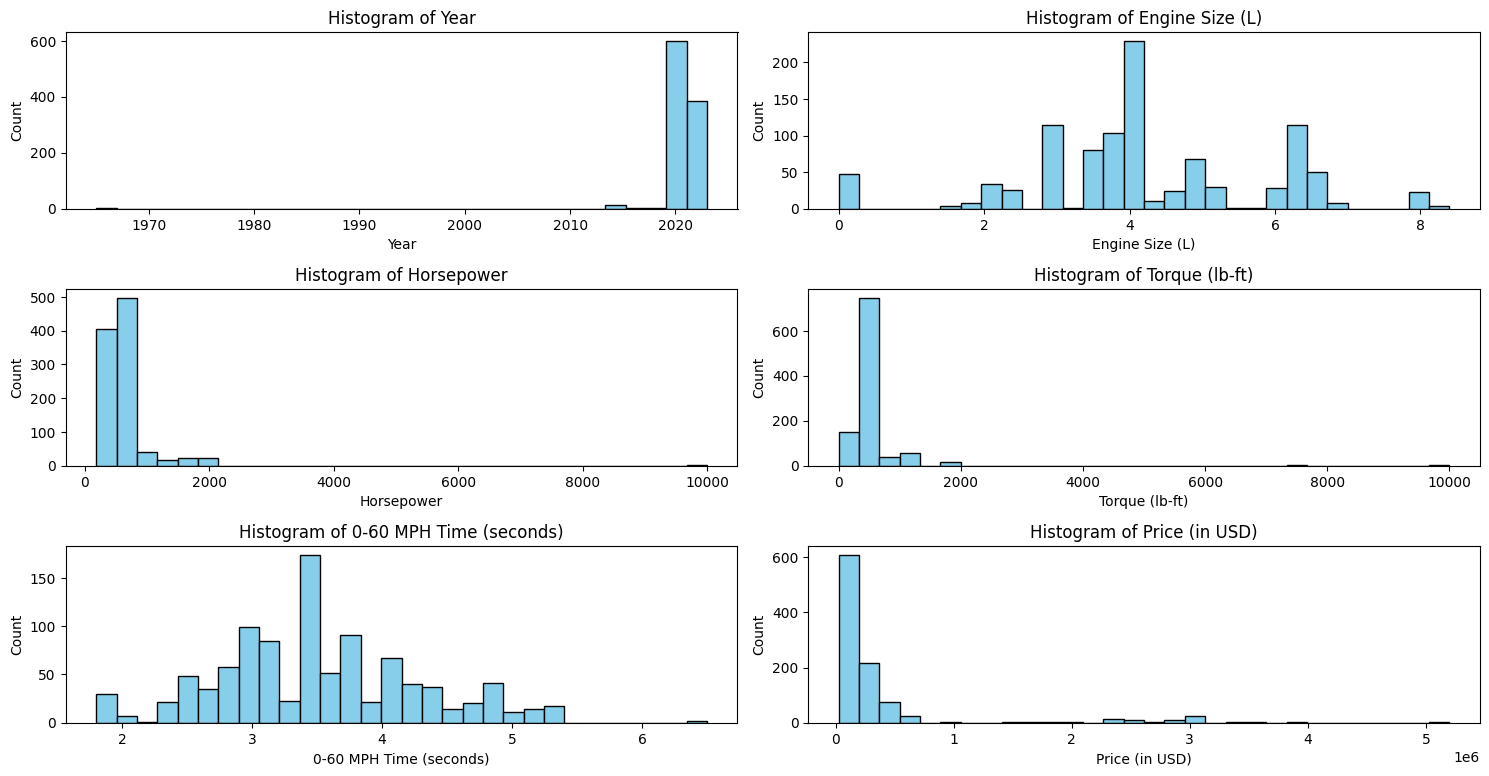

In [15]:
numerical_cols = Sport_car.select_dtypes(include=['float64', 'int64']).columns

# Histogram for evry Feature
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols)//2 + 1, 2, i+1)
    plt.hist(Sport_car[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

Scatter plotting between evry Feature and Price:

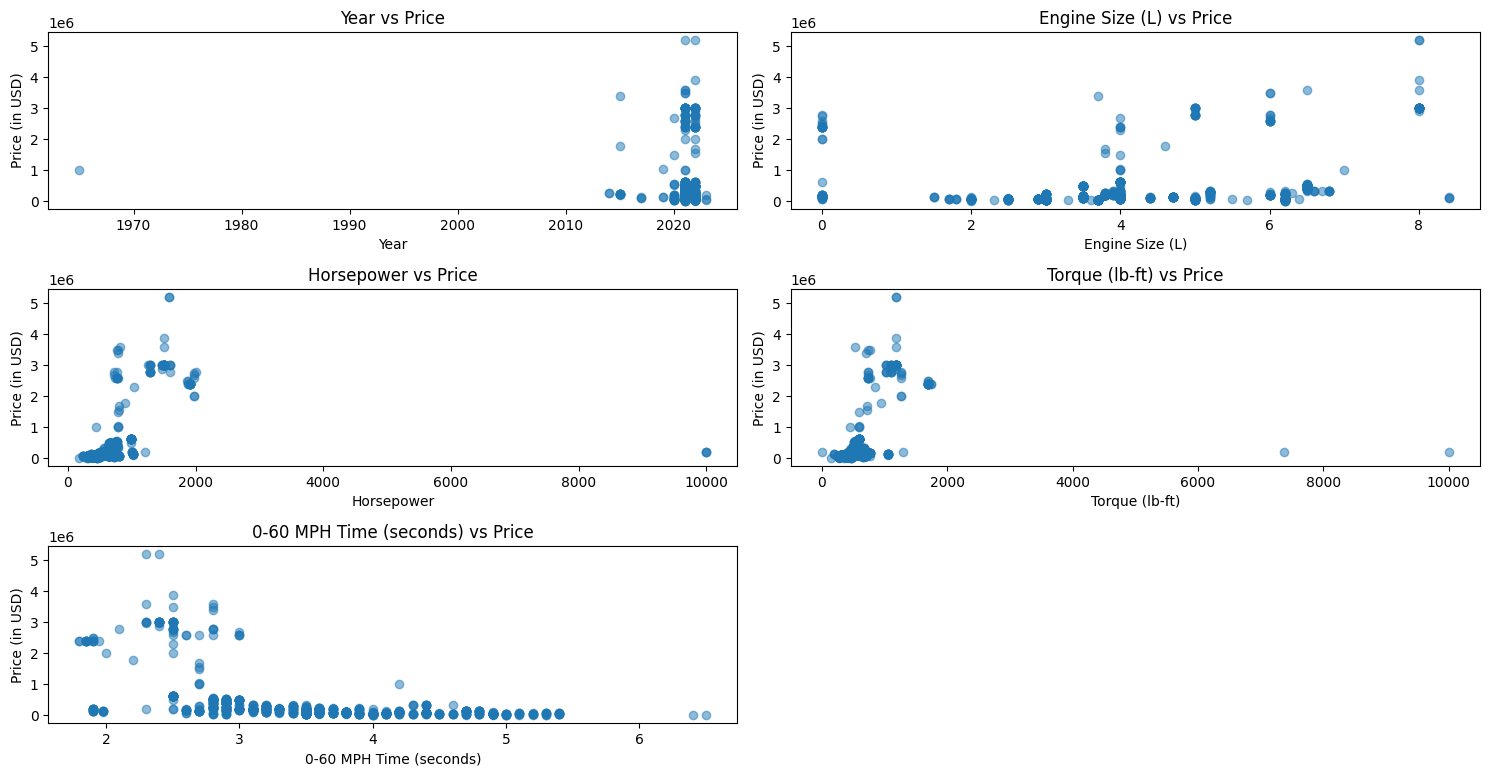

In [16]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    if col != 'Price (in USD)':
        plt.subplot(len(numerical_cols)//2 + 1, 2, i+1)
        plt.scatter(Sport_car[col], Sport_car['Price (in USD)'], alpha=0.5)
        plt.title(f'{col} vs Price')
        plt.xlabel(col)
        plt.ylabel('Price (in USD)')
plt.tight_layout()
plt.show()

### **Outliers**

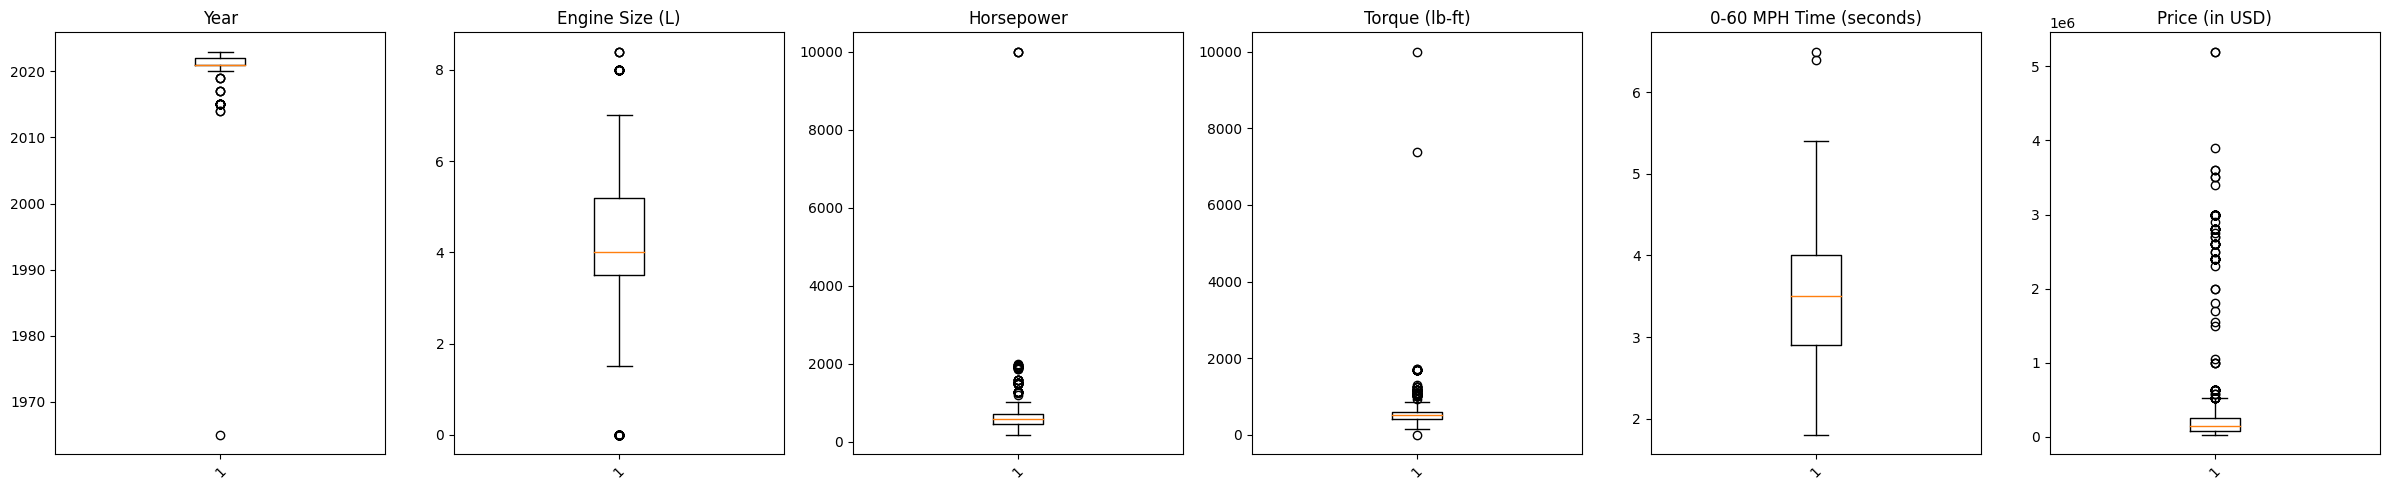

In [17]:
# numerical cols
numerical_col = Sport_car.select_dtypes(include=['float64', 'int64'])
num_cols = len(numerical_col.columns)

# Boxplots
fig, axes = plt.subplots(1, num_cols, figsize=(4*num_cols, 5))

for i, col in enumerate(numerical_col.columns):
    axes[i].boxplot(Sport_car[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
Sport_car.describe()

,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1.007000e+03
mean,2021.201589,4.183416,657.984111,559.369414,3.513406,3.820359e+05
std,2.019802,1.646073,593.017842,440.513177,0.777639,7.383227e+05
min,1965.000000,0.000000,181.000000,0.000000,1.800000,2.500000e+04
25%,2021.000000,3.500000,454.000000,406.000000,2.900000,7.180000e+04
50%,2021.000000,4.000000,591.000000,509.000000,3.500000,1.400000e+05
75%,2022.000000,5.200000,708.500000,604.000000,4.000000,2.500000e+05
max,2023.000000,8.400000,10000.000000,10000.000000,6.500000,5.200000e+06


In [19]:
# Remove outliers from Horsepower and Torque and Price
Sport_car_clean = Sport_car[
    (Sport_car['Horsepower'] <= 2000) &
    (Sport_car['Torque (lb-ft)'] <= 2000) &
    (Sport_car['Price (in USD)'] <= 2_000_000)]

In [20]:
# Cap at 99th percentile
for col in ['Horsepower', 'Torque (lb-ft)', 'Price (in USD)']:
    upper_limit = Sport_car[col].quantile(0.99)
    Sport_car[col] = np.where(Sport_car[col] > upper_limit, upper_limit, Sport_car[col])

Boxplot after removing Outliers:

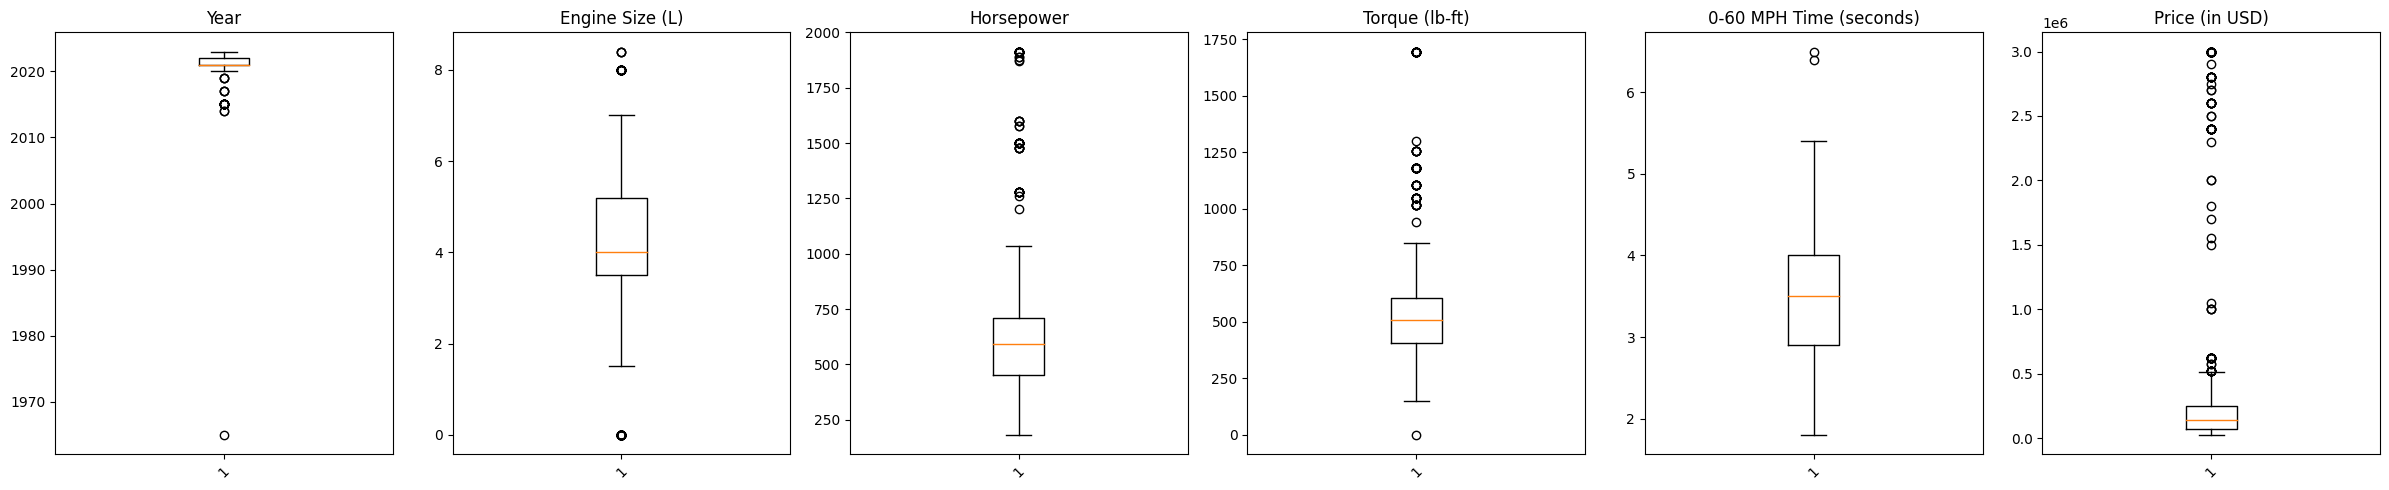

In [21]:
# numerical cols
numerical_col = Sport_car.select_dtypes(include=['float64', 'int64'])
num_cols = len(numerical_col.columns)

# Boxplots
fig, axes = plt.subplots(1, num_cols, figsize=(4*num_cols, 5))

for i, col in enumerate(numerical_col.columns):
    axes[i].boxplot(Sport_car[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## **FeatureExtraction**

Use **OneHotEncodde**

In [22]:
# chose categorical cols
categorical_cols = ['Car Make', 'Car Model']
# apply onehotencooder
Sport_car = pd.get_dummies(Sport_car, columns=categorical_cols)

In [23]:
Sport_car.head()

,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Car Make_Acura,Car Make_Alfa Romeo,Car Make_Alpine,Car Make_Ariel,...,Car Model_Taycan Turbo S,Car Model_Urus,Car Model_Vantage,Car Model_Viper,Car Model_Viper ACR,Car Model_WRX STI,Car Model_Wraith,Car Model_Z4 M40i,Car Model_Z4 Roadster,Car Model_i8
0,2022,3.0,379.0,331.0,4.0,101200.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2021,5.2,630.0,443.0,2.8,274390.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2022,3.9,661.0,561.0,3.0,333750.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2022,5.2,562.0,406.0,3.2,142700.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2021,4.0,710.0,568.0,2.7,298000.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## **Splitting Data**

In [24]:
X = Sport_car.drop(['Price (in USD)'],axis=1)
y = Sport_car['Price (in USD)']

In [25]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44, shuffle =True)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (755, 219)
X_test shape is  (252, 219)
y_train shape is  (755,)
y_test shape is  (252,)


## **Modeling**

We use **Gradient Boosting Regressor Model**

In [26]:
#Applying Gradient Boosting Regressor Model
GBRModel = GradientBoostingRegressor(n_estimators=700,max_depth=2,learning_rate = .08 ,random_state=33)
GBRModel.fit(X_train, y_train)

#Calculating Prediction
y_pred = GBRModel.predict(X_test)
print('Predicted Value for GBRModel is : ' , y_pred[:10])

Predicted Value for GBRModel is :  [  68038.04155171   74912.80485393  236677.51474595   70319.36319694
 2380817.244943     59433.13533645  256408.89425755  130995.97874829
  255722.89666462  609094.80980941]


## **Evaluation**

In [27]:
#Calculating Details
print('GBRModel Train Score is : ' , GBRModel.score(X_train, y_train))
print('GBRModel Test Score is : ' , GBRModel.score(X_test, y_test))

GBRModel Train Score is :  0.9974287354965211
GBRModel Test Score is :  0.950270876347485


In [28]:
# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("GBR Model Evaluation Metrics:")
print(f"R² Score : {r2:.4f}")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

GBR Model Evaluation Metrics:
R² Score : 0.9503
Mean Absolute Error (MAE) : 39397.43
Root Mean Squared Error (RMSE) : 162113.29


Comparison between Actual vs Predicted Prices by using Scatter plot:

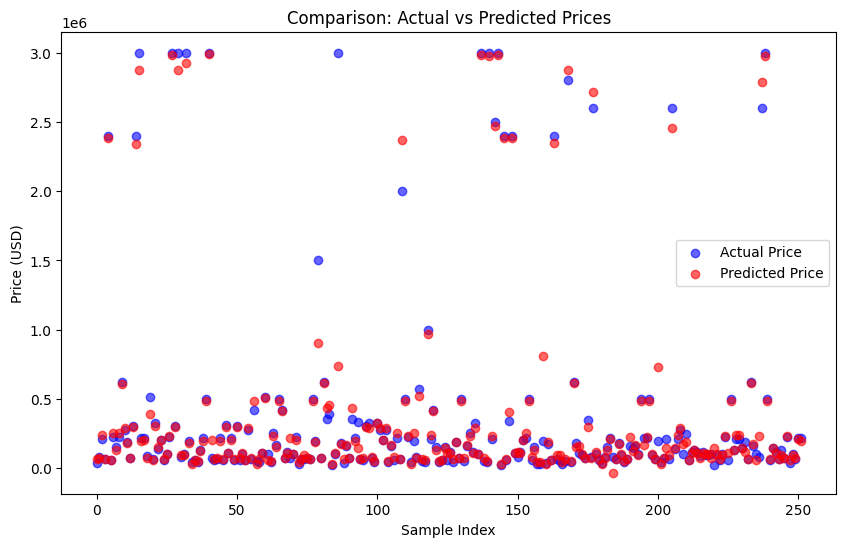

In [29]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='Actual Price')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted Price')
plt.title('Comparison: Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

To show Feature importance:

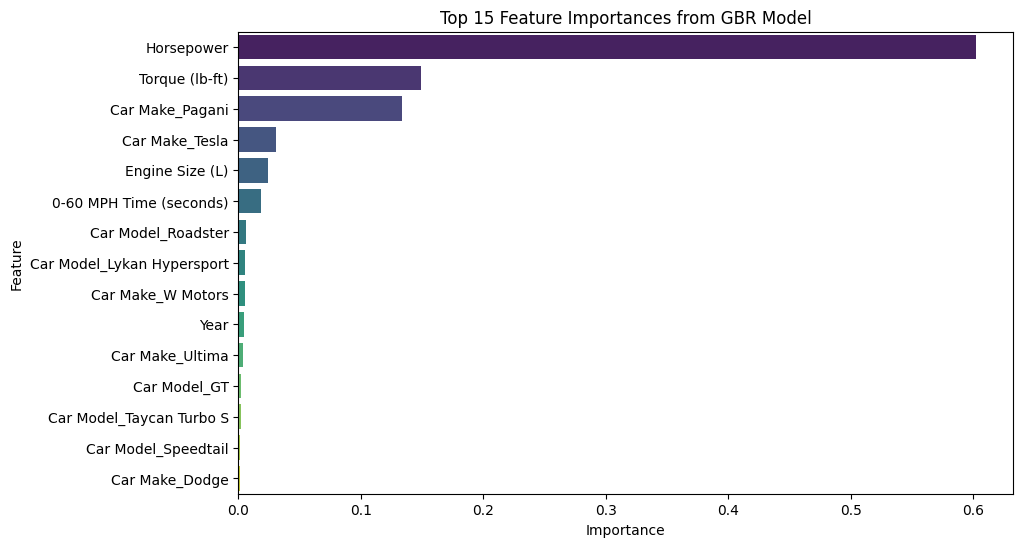

In [30]:
# Feature importance
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': GBRModel.feature_importances_})

# accending feature and take 15 Features
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 15 Feature Importances from GBR Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Coorlearion at heatmap:

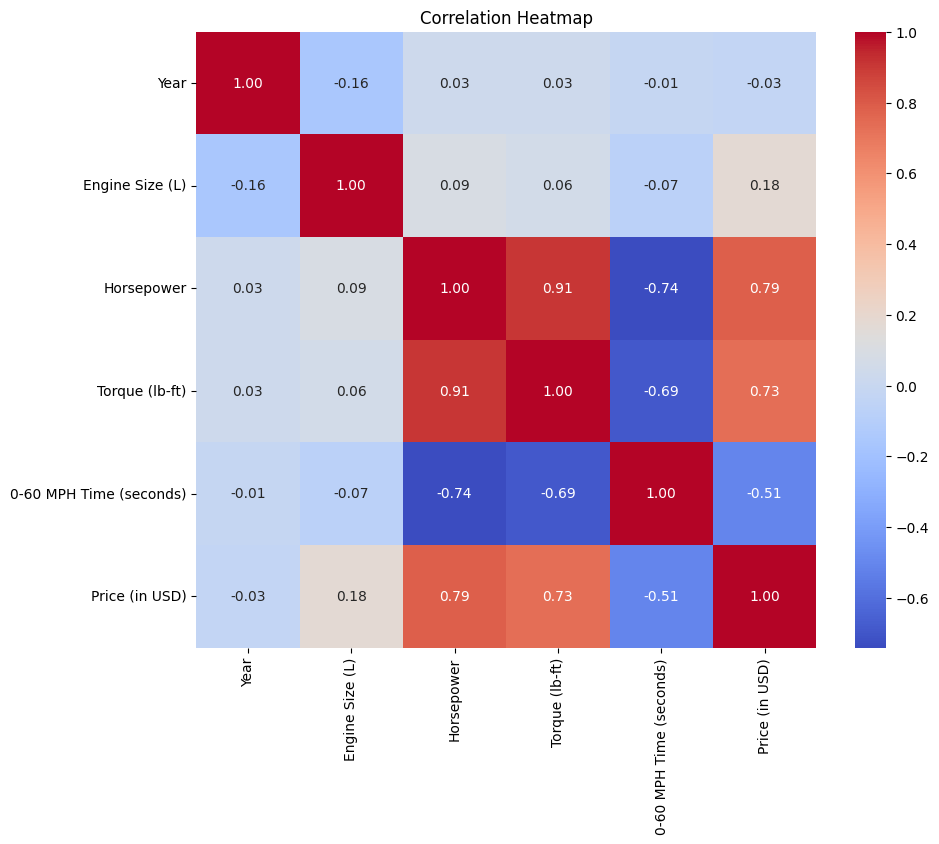

In [31]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(Sport_car[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## **Conclusion**

1-Key Observations from Analysis and Models:

The numerical data was cleaned, handling invalid values like "Electric", "-", "1000+".
Both Linear Regression and Gradient Boosting Regressor (GBR) were used to predict sports car prices.
Model performance:
Linear Regression: R² Train ≈ 0.998, R² Test ≈ 0.936 → very good, but sensitive to outliers.
GBR: R² Train ≈ 0.997, R² Test ≈ 0.950 → better generalization on the test set and captures non-linear relationships.
2. Most Influential Features on Price:

From Feature Importance (GBR):
Horsepower, Torque, Engine Size → strong positive impact on price.
0-60 MPH Time → negative correlation, faster cars tend to have higher prices.
Car Make / Model (One-Hot Encoded) → high impact for premium brands like Ferrari, Lamborghini, Pagani.
3. Suggestions for Future Improvements:

Handle outliers more effectively or apply transformations to reduce their impact.
Include additional features such as car weight, fuel type, or market ratings.
Experiment with advanced models like XGBoost or LightGBM with hyperparameter tuning.
Create an interactive dashboard to visualize predictions.
Study the effect of Year more deeply to analyze price trends over time.